In [1]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

# Change Directory
import os
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data') # Laptop @ J: # Desktop @ J:
print('-----------------------------------------------------')
print('WD: ', os.getcwd())
print('-----------------------------------------------------')
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("default") # notebook, paper, poster
%matplotlib inline
from matplotlib import ticker
from matplotlib.dates import HourLocator, DateFormatter
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator, MultipleLocator, AutoMinorLocator
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import datetime
years  =  mdates.YearLocator()
months =  mdates.MonthLocator()
days   =  mdates.DayLocator()
hours  =  mdates.HourLocator()
month_name = DateFormatter("%b")
day_name = DateFormatter('%d')


from scipy.stats import zscore
import scipy.stats as stats

# Import Water Data (Amon_2016_Yenisei)
waterfile = 'Amon_2016_Yenisei_Water.txt'
water = pd.read_csv(waterfile, sep ='\t',  parse_dates=[0])
water.columns = water.columns.str.strip()
water.index = water['date_time']
water['year'] = pd.DatetimeIndex(water['date_time']).year
water['month'] = pd.DatetimeIndex(water['date_time']).month
water['day'] = pd.DatetimeIndex(water['date_time']).day
water['hour'] = pd.DatetimeIndex(water['date_time']).hour
water = water.sort_values(by = ['year','month', 'day', 'hour'], ascending=True) 
water = water.dropna(how='any')

# Import Air Data (Amon_2016_Yenisei)
airfile = 'Amon_2016_Yenisei_Air.txt'
air = pd.read_csv(airfile, sep ='\t',  parse_dates=[0])
air.columns = air.columns.str.strip()
air.index = air['date_time']
air['year'] = pd.DatetimeIndex(air['date_time']).year
air['month'] = pd.DatetimeIndex(air['date_time']).month
air['day'] = pd.DatetimeIndex(air['date_time']).day
air['hour'] = pd.DatetimeIndex(air['date_time']).hour
air = air.sort_values(by = ['year','month', 'day', 'hour'], ascending=True) 
air = air.dropna(how='any')

# Move Anomalies to a new dataframe
water_anomalies_co2_w = water[water['co2_w'] > 1200]
water_anomalies_ico2_w = water[water['ico2_w'] >= -10]
water_anomalies_ch4_w = water[water['ch4_w'] > 500]

air_anomalies_ico2_a = air[air['ico2_a'] <= -12]
air_anomalies_co2_a1 = air[air['co2_a'] > 550]
air_anomalies_co2_a2 = air[air['co2_a'] < 350]
air_anomalies_ch4_a = air[air['ch4_a'] < 1.6]

# Concatenate all the anomalies into a single dataframe
water_anomalies = pd.concat([water_anomalies_co2_w, 
                             water_anomalies_ico2_w, 
                             water_anomalies_ch4_w], axis=0)

air_anomalies = pd.concat([air_anomalies_ico2_a, 
                           air_anomalies_co2_a1, 
                           air_anomalies_co2_a2,
                           air_anomalies_ch4_a], axis=0)

# Remove Anomalies from Origional Dataframe
water = water[~water.index.isin(water_anomalies_co2_w.index)]
water = water[~water.index.isin(water_anomalies_ico2_w.index)]
water = water[~water.index.isin(water_anomalies_ch4_w.index)]
air = air[~air.index.isin(air_anomalies_ico2_a.index)]
air = air[~air.index.isin(air_anomalies_co2_a1.index)]
air = air[~air.index.isin(air_anomalies_co2_a2.index)]
air = air[~air.index.isin(air_anomalies_ch4_a.index)]

# Remove Some Mo
water_anomalies_lwr_w = water[water['lwr_w'] < 271.5696741]

# Remove Anomalies from Origional Dataframe
water = water[~water.index.isin(water_anomalies_lwr_w.index)]

# Folder to Save Images (# Laptop @ J: ##### Desktop @ J:)
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\Chomiak_RF_Yenisey')

# Rank Features for Random Forest
from IPython.core.display import display, HTML
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OneHotEncoder
from sklearn.inspection import permutation_importance

-----------------------------------------------------
WD:  J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data
-----------------------------------------------------


In [2]:
# Target Variable
y = water['co2_w']

# Combine the dummy variables with other predictors
X = water[['lat_w', 'lon_w', 'u_w', 
           'swr_w', 'lwr_w', 'rh_w', 't_air_w', 
           't_dew_w', 't_adcp_w', 'p_rad_w', 
           'sog_w', 'hour']]

# Rename columns to remove the '_w'
X.columns = [col.replace('_w', '') for col in X.columns]

In [3]:
%%time
# Split the data into two sets for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Train the Random Forests model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = rf_model.predict(X_test)

# Residual Analysis
residuals = y_test - y_pred_rf

# Calculate R-squared
r2 = r2_score(y_test, y_pred_rf)
print("R-squared (R²):", r2)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred_rf)
print("Mean Absolute Error (MAE):", mae)

# Residual Stats
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)
min_residuals = np.min(residuals)
max_residuals = np.max(residuals)
print()
print(f"Mean of Residuals: {mean_residuals}")
print(f"Standard Deviation of Residuals: {std_residuals}")
print(f"Minimum of Residuals: {min_residuals}")
print(f"Maximum of Residuals: {max_residuals}")

R-squared (R²): 0.9740063075883848
Mean Absolute Error (MAE): 6.9987719199658684

Mean of Residuals: 0.23432248995375016
Standard Deviation of Residuals: 19.477027368285306
Minimum of Residuals: -214.22032168199962
Maximum of Residuals: 436.3109399930001
Wall time: 7.37 s


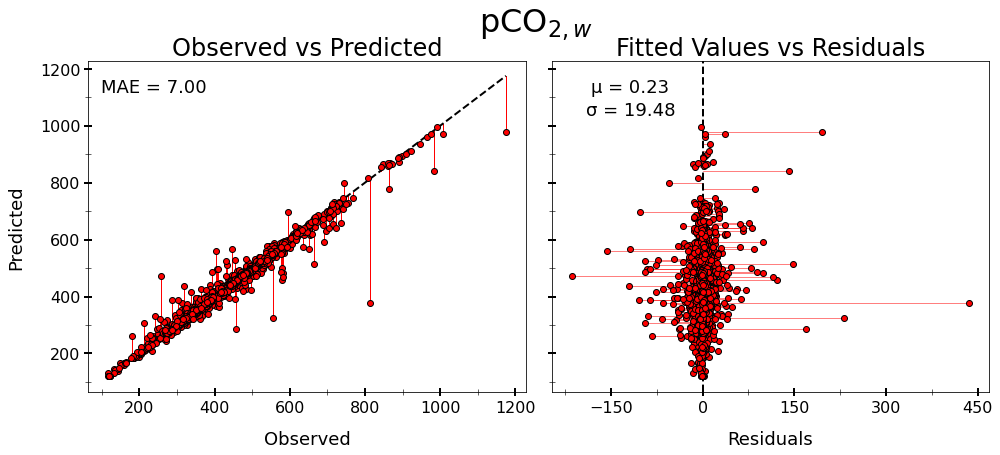

In [4]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    
# Observed vs Predicted
ax[0].scatter(y_test, y_pred_rf, c='r', ec='black', zorder=2)
ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, zorder=1)
ax[0].set_xlabel('Observed', labelpad=15, fontsize=18)
ax[0].set_ylabel('Predicted', labelpad=15, fontsize=18)
ax[0].set_title('Observed vs Predicted', fontsize=24)
# Residual lines
for i, j in zip(y_test, y_pred_rf):
    ax[0].plot([i, i], [i, j], color='red', lw=1, zorder=0)

# Plot 2: Residuals vs Fitted Values
ax[1].scatter(residuals, y_pred_rf, c='r', ec='black', zorder=2)
ax[1].axvline(0, color='k', linestyle='--', lw=2, zorder=1)
ax[1].set_xlabel('Residuals', labelpad=15, fontsize=18)
ax[1].set_title('Fitted Values vs Residuals', fontsize=24)

# Adding lines for residuals in the Residuals vs Fitted Values plot
for pred, resid in zip(y_pred_rf, residuals):
    ax[1].plot([resid, 0], [pred, pred], color='red', lw=0.5, zorder=0)

ax[0].text(0.15, 0.92, f"MAE = {mae:.2f}", fontsize=18, color='black', 
           horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
ax[1].text(0.18, 0.92, f"μ = {mean_residuals:.2f}", fontsize=18, color='black', 
           horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
ax[1].text(0.18, 0.85, f"σ = {std_residuals:.2f}", fontsize=18, color='black', 
           horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)

for ax in ax.flat:
    ax.xaxis.set_major_locator(MaxNLocator(6))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16, width=2)
    ax.xaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=16)
    ax.yaxis.set_major_locator(MaxNLocator(6))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16, width=2)
    ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=16)

fig.tight_layout(pad=1)

plt.suptitle('pCO$_{2,w}$', fontsize=32, c='black', x=0.535, y=1.045)

#±
fig.savefig('Chomiak_RF_CO2w_30min_residdy.png', dpi = 600, bbox_inches='tight')

In [5]:
# Get feature importances
importances = rf_model.feature_importances_

# Convert the importances into a DataFrame
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Sort by Importance in descending order
sorted_importance_df = feature_importances.sort_values(by='importance', ascending=False)

C:\Users\wbcho\AppData\Local\Temp/ipykernel_19896/1423174335.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(custom_labels)


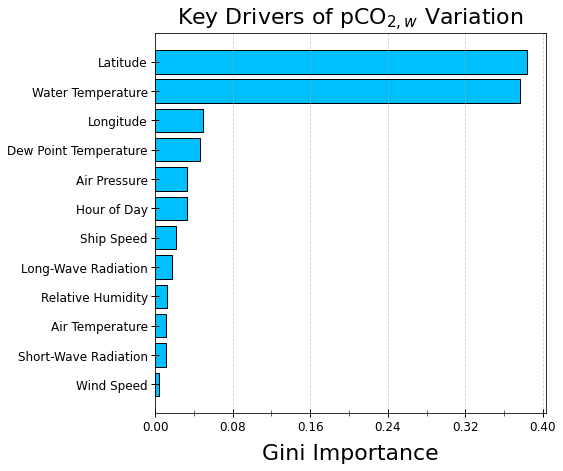

In [6]:
# Create a mapping from feature name to display name
name_map = {
    'lat': 'Latitude', 
    'lon': 'Longitude', 
    'hour': 'Hour of Day', 
    't_adcp': 'Water Temperature', 
    't_air': 'Air Temperature',
    't_dew': 'Dew Point Temperature', 
    'rh': 'Relative Humidity', 
    'p_rad': 'Air Pressure', 
    'swr': 'Short-Wave Radiation', 
    'lwr': 'Long-Wave Radiation',
    'u': 'Wind Speed', 
    'sog': 'Ship Speed', 
}

# Get the display names corresponding to the sorted features
custom_labels = [name_map[feature] for feature in sorted_importance_df['feature']]

# Plot
fig, ax = plt.subplots(figsize=(7, 7))
ax.barh(sorted_importance_df['feature'], sorted_importance_df['importance'], color='deepskyblue', ec='black')
#ax.set_title('Feature Importance (CO$_{2,w}$)', fontsize=24)
ax.set_title("Key Drivers of pCO$_{2,w}$ Variation", fontsize=22)
#ax.set_xlabel(r"Permutation Importance (Drop in $R^2$)", fontsize=16)
ax.set_xlabel("Gini Importance", fontsize=22, labelpad=10)

#ax[1].set_title('$^{13}$CO$_{2,w}$', fontsize=24)
#ax[2].set_title('CH$_{4,w}$', fontsize=24)
#ax[3].set_title('$^{13}$CH$_{4,w}$', fontsize=24)
# Set the custom y-axis labels
ax.set_yticklabels(custom_labels)
# Invert y-axis only once after plotting all subplots
ax.invert_yaxis()
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=12, width=1.0)
ax.xaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=12)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=12, width=1.0)
ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.6)
#ax.set_xlim(0, 0.99)
# Common y-label
#fig.text(0.04, 0.5, 'Features', va='center', rotation='vertical', fontsize=14)

fig.savefig('Chomiak_RF_CO2w_30min_fi_gini.png', dpi = 600, bbox_inches='tight')

In [7]:
%%time

# Number of folds
k = 5  # or 10, depending on your preference and data size

# Perform k-fold cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=k, scoring='neg_mean_absolute_error')

# Calculate the average and standard deviation of the cross-validation scores
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print(f"Average MAE over {k} folds: {-mean_cv_score:.2f}")
print(f"Standard Deviation over {k} folds: {std_cv_score:.2f}")

Average MAE over 5 folds: 7.76
Standard Deviation over 5 folds: 0.50
Wall time: 28.2 s


In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
perm_importances = []

for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Train the model
    rf_model.fit(X_train_fold, y_train_fold)
    
    # Perform permutation importance
    results = permutation_importance(rf_model, X_test_fold, y_test_fold, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error')

    # Store the importances
    perm_importances.append(results.importances_mean)

# Calculate the average importances across all folds
average_perm_importances = np.mean(perm_importances, axis=0)

# Create a DataFrame to view the feature importances
feature_importances_df = pd.DataFrame({'feature': X_train.columns, 'permutation_importance': average_perm_importances})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='permutation_importance', ascending=False)

# Display the feature importances
print(feature_importances_df)

   feature  permutation_importance
0      lat               68.904919
8   t_adcp               53.069717
1      lon               18.408282
9    p_rad               13.838022
7    t_dew                9.750243
11    hour                8.840265
4      lwr                8.318958
10     sog                8.284347
3      swr                4.525439
5       rh                4.516717
6    t_air                4.326491
2        u                1.141401


C:\Users\wbcho\AppData\Local\Temp/ipykernel_19896/1963258727.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(custom_labels)


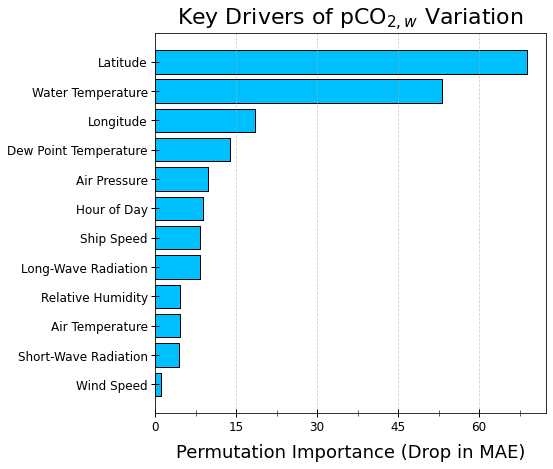

In [9]:
# Plot
fig, ax = plt.subplots(figsize=(7, 7))
ax.barh(feature_importances_df['feature'], feature_importances_df['permutation_importance'], color='deepskyblue', ec='black')
#ax.set_title('Feature Importance (CO$_{2,w}$)', fontsize=24)
ax.set_title("Key Drivers of pCO$_{2,w}$ Variation", fontsize=22)
ax.set_xlabel(r"Permutation Importance (Drop in MAE)", fontsize=18, labelpad=10)
#ax.set_xlabel("Gini Importance", fontsize=22, labelpad=10)

#ax[1].set_title('$^{13}$CO$_{2,w}$', fontsize=24)
#ax[2].set_title('CH$_{4,w}$', fontsize=24)
#ax[3].set_title('$^{13}$CH$_{4,w}$', fontsize=24)
# Set the custom y-axis labels
ax.set_yticklabels(custom_labels)
# Invert y-axis only once after plotting all subplots
ax.invert_yaxis()
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=12, width=1.0)
ax.xaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=12)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=12, width=1.0)
ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.6)

fig.savefig('Chomiak_RF_CO2w_30min_fi_permutation.png', dpi = 600, bbox_inches='tight')